In [1]:
import rebound
import numpy as np
import pandas as pd
import systems.sys_params as sysp
import forecaster.mr_forecast as mr

In [2]:
nomass_sys, vaneye_sys, danjh_sys = sysp.get_system_lists()

### Testing

In [3]:
system = vaneye_sys[0]
print("Analyzing System %s"%system)
orb_e = 2

samples = np.load("systems/data_files/van_eylen/%s/chain_period_eccentricity_finalone.dat.npy"%system)
#print(np.mean(data["e1"]), np.mean(data["e2"]), np.mean(data["e3"]))
print(np.median(np.abs(samples[:,:,orb_e])), np.median(np.abs(samples[:,:,orb_e+6])), np.median(np.abs(samples[:,:,orb_e+12])))
print(samples.shape)

Analyzing System K00041
(0.25456024049330672, 0.34180618244506711, 0.35049462098832818)
(200, 10000, 20)


In [4]:
system = vaneye_sys[3]
print("Analyzing System %s"%system)
e1 = np.loadtxt("systems/data_files/van_eylen/%s/eccentricity_list%s.01.txt"%(system, system))
e2 = np.loadtxt("systems/data_files/van_eylen/%s/eccentricity_list%s.02.txt"%(system, system))
e3 = np.loadtxt("systems/data_files/van_eylen/%s/eccentricity_list%s.03.txt"%(system, system))
print(np.median(np.abs(e1)), np.median(np.abs(e2)), np.median(np.abs(e3)))
print(e1.shape)

Analyzing System K00285
(0.182175758386, 0.13877419265300001, 0.25476361144100002)
(40000,)


### Get M

In [5]:
system = vaneye_sys[0]
n_systems = 100   #only load a subset, generating masses for 20,000 samples is expensive

print("Analyzing System %s"%system)

# get periods, determine proper ordering (not ordered by default!)
P1 = float(open("systems/data_files/van_eylen/%s/period_%s.01.txt"%(system, system), 'r').readlines()[1].split()[0])
P2 = float(open("systems/data_files/van_eylen/%s/period_%s.02.txt"%(system, system), 'r').readlines()[1].split()[0])
P3 = float(open("systems/data_files/van_eylen/%s/period_%s.03.txt"%(system, system), 'r').readlines()[1].split()[0])
sort_index = [x for _,x in sorted(zip([P1, P2, P3],["1","2","3"]))]
orb_params = []
for index in sort_index:
    orb_params += ["T%s"%index,"b%s"%index,"e%s"%index,"w%s"%index,"r%s/rs"%index,"Fs%s"%index]
orb_params += ["gam1","gam2"]

samples = np.load("systems/data_files/van_eylen/%s/chain_period_eccentricity_finalone.dat.npy"%system)
data = pd.DataFrame(samples.reshape(-1, samples.shape[2]), columns=orb_params)[0:n_systems] # just take a subset

# absolute value. Vincent used negatives to keep track of longer/shorter transits due to angles
for c in ["e1","e2","e3"]:
    data[c] = data[c].abs()
    
# adding period to each column
data["P%s"%sort_index[0]] = P1
data["P%s"%sort_index[1]] = P2
data["P%s"%sort_index[2]] = P3

# get probabilistic masses
Rs = float(open("systems/data_files/van_eylen/%s/stellar_parameters.txt"%system, 'r').readlines()[2].split()[1])
data["m1"] = mr.Rpost2M(data["r1/rs"]*Rs/0.009158, unit='Earth', grid_size=1e3)
data["m2"] = mr.Rpost2M(data["r2/rs"]*Rs/0.009158, unit='Earth', grid_size=1e3)
data["m3"] = mr.Rpost2M(data["r3/rs"]*Rs/0.009158, unit='Earth', grid_size=1e3)

Analyzing System K00041


So... when you get it working though, I *think* the task is for you to calculate Mean anomaly at mid-transit:
$$
E_{@mid-transit} = 2*atan(sqrt(1-e/(1+e)))*tan(1/2*(pi/2-omega))  \\
M_{@mid-transit} = E - e*sin(omega)
$$

And then wind the clock back so that they are all consistent for a single time, i.e. for the smallest mid-transit time. So assuming (for simplicity for now) that $T1$ is always smallest:
$$
M_{2, @mid-transit-of-planet-1} = M_{2, @mid-transit} - n_2(T_2 - T_1) \\
M_{3, @mid-transit-of-planet-1} = M_{3, @mid-transit} - n_3(T_3 - T_1)
$$

In [6]:
min_transit_times = np.min(np.array((data["T1"],data["T2"],data["T3"])), axis=0)
M_buffer = 0.025 # extra offset so that they cross in rebound at pi/2 - omega

for i in ["1","2","3"]:
    e, w, n = data["e%s"%i], data["w%s"%i], 2*np.pi/data["P%s"%i]
    E_midtr = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan((np.pi/2 - w)/2))
    M_midtr = E_midtr - e*np.sin(E_midtr)
    data["M%s"%i] = M_midtr + n*(min_transit_times - data["T%s"%i] - M_buffer)  

In [7]:
data.head()

,T2,b2,e2,w2,r2/rs,Fs2,T1,b1,e1,w1,...,gam2,P2,P1,P3,m1,m2,m3,M1,M2,M3
0,0.005574,0.046150,0.381255,-0.074812,0.013396,0.999998,0.001042,0.321161,0.528810,0.048158,...,0.279620,12.815909,6.887037,35.33313,1.205600,24.909922,1.942618,0.513255,0.873549,0.598935
1,0.005555,0.079391,0.412442,-0.057245,0.013378,0.999998,0.001060,0.301201,0.539134,0.070224,...,0.278882,12.815909,6.887037,35.33313,1.546320,6.743228,4.014835,0.484087,0.799800,0.582165
2,0.005555,0.079391,0.412442,-0.057245,0.013378,0.999998,0.001060,0.301201,0.539134,0.070224,...,0.278882,12.815909,6.887037,35.33313,9.015296,6.743228,3.472255,0.484087,0.799800,0.582165
3,0.005552,0.080372,0.414169,-0.056986,0.013378,0.999998,0.001066,0.298338,0.547650,0.071481,...,0.278643,12.815909,6.887037,35.33313,1.514577,7.326556,2.200065,0.469918,0.796343,0.585116
4,0.005552,0.080372,0.414169,-0.056986,0.013378,0.999998,0.001066,0.298338,0.547650,0.071481,...,0.278643,12.815909,6.887037,35.33313,2.440481,7.636879,3.331161,0.469918,0.796343,0.585116


### Confirm in Rebound that the difference in mid-transit times are preserved

In [60]:
def construct_sim(sim, data, system, i=0):
    Ms = float(open("systems/data_files/van_eylen/%s/stellar_parameters.txt"%system, 'r').readlines()[3].split()[1])
    
    sim.add(m=Ms)
    for p in ["1","2","3"]:
        e, w, P, M = data["e%s"%p][i], data["w%s"%p][i], data["P%s"%p][i], data["M%s"%p][i]
        m = data["m%s"%p][i]*0.000003003
        sim.add(m=m, P=P*2*np.pi/365., e=e, omega=w, M=M) #G=1 units!
    sim.move_to_com()
    sim.dt = sim.particles[1].P/1000
    return sim

In [168]:
def construct_sim(sim, data, system, i=0):
    Ms = float(open("systems/data_files/van_eylen/%s/stellar_parameters.txt"%system, 'r').readlines()[3].split()[1])
    
    sim.add(m=Ms)
    #for p in ["1","2","3"]:
    for p in ["1"]:
        e, w, P, M = data["e%s"%p][i], data["w%s"%p][i], data["P%s"%p][i], data["M%s"%p][i]
        m = data["m%s"%p][i]*0.000003003
        sim.add(m=m, P=P*2*np.pi/365., e=0.1, omega=0, M=3*np.pi/2, Omega=3*np.pi/2, inc=20*np.pi/180) #G=1 units!
    sim.move_to_com()
    sim.dt = sim.particles[1].P/1000
    return sim

In [169]:
# test on rebound simulation
import rebound
sim = rebound.Simulation()
sim.getWidget(size=(200,200),scale=0.1,orientation=(1,0,0,1))

In [170]:
i_sys = 0
sim = construct_sim(sim, data, system, i_sys)

In [171]:
import time
for t in np.linspace(0,2,10):
    sim.integrate(t)
    time.sleep(1)

In [15]:
# sample mid-transit times
times = np.linspace(0,sim.particles[1].P/55,5000)
E0 = sim.calculate_energy()
dE = []
f1, f2, f3 = [], [], []
printed = [False, False, False]
midtransit_time = np.zeros(3)
for t in times:
    sim.integrate(t)
    f1.append(sim.particles[1].f - np.pi/2 + sim.particles[1].omega)
    f2.append(sim.particles[2].f - np.pi/2 + sim.particles[2].omega)
    f3.append(sim.particles[3].f - np.pi/2 + sim.particles[3].omega)
    df = [f1[-1], f2[-1], f3[-1]]
    for i in range(3):
        if np.abs(df[i]) < 5e-5 and printed[i]==False and sim.t > 0:
            print("transit-time of planet %d ="%(i+1), sim.t*365/(2*np.pi))
            printed[i]=True
            midtransit_time[i] = sim.t*365/(2*np.pi)
    if all(printed):
        break
print("Energy error=%e"%(np.abs((sim.calculate_energy() - E0)/E0)))
print("\nSimulated matrix of difference in mid-transit times (days)")
print(midtransit_time[:, None] - midtransit_time[None, :])
print("\nTrue matrix of difference in mid-transit times (days):")
true_midtr = np.array((data["T1"][i_sys], data["T2"][i_sys], data["T3"][i_sys]))
print(true_midtr[:, None] - true_midtr[None, :])

('transit-time of planet 3 =', 0.02455300508108022)
('transit-time of planet 2 =', 0.03410417406374076)
('transit-time of planet 1 =', 0.041105030909669944)
Energy error=0.000000e+00

Simulated matrix of difference in mid-transit times (days)
[[ 0.          0.00700086  0.01655203]
 [-0.00700086  0.          0.00955117]
 [-0.01655203 -0.00955117  0.        ]]

True matrix of difference in mid-transit times (days):
[[ 0.          0.00690076  0.01616152]
 [-0.00690076  0.          0.00926076]
 [-0.01616152 -0.00926076  0.        ]]


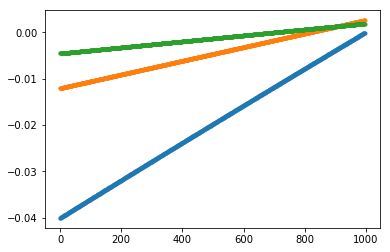

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(f1, '.')
plt.plot(f2, '.')
plt.plot(f3, '.')

In [23]:
data = pd.read_csv("systems/Kepler-431_data.csv")[0:10]
data

,Unnamed: 0,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,m3,MA3,P3,e3,w3,Ms
0,0,0.190323,1.922614,6.803,0.013274,2.076118,0.548149,5.444703,8.703,0.003679,5.690501,0.504507,5.983768,11.922,0.000372,4.412395,1.071
1,1,0.362025,0.952130,6.803,0.000496,1.162948,0.276461,4.141902,8.703,0.001693,4.375519,1.000302,1.206019,11.922,0.025620,6.009131,1.071
2,2,1.109612,2.163423,6.803,0.119979,3.065306,0.078009,3.863810,8.703,0.070324,2.642439,0.595567,5.599364,11.922,0.000017,0.285293,1.071
3,3,0.139435,3.290191,6.803,0.134269,6.111329,0.620793,2.178322,8.703,0.012962,6.070029,1.942618,0.395234,11.922,0.000155,2.807998,1.071
4,4,0.239099,4.372711,6.803,0.000517,0.758024,0.796238,0.305502,8.703,0.034731,4.983430,2.024899,0.896373,11.922,0.000118,1.670759,1.071
5,5,0.583342,1.571982,6.803,0.000261,5.592587,0.220063,6.025755,8.703,0.000192,3.556212,0.779893,0.907157,11.922,0.000668,0.447355,1.071
6,6,0.215545,2.320363,6.803,0.001354,3.496218,0.265228,1.806268,8.703,0.012765,5.161489,3.331161,3.043075,11.922,0.007102,1.469791,1.071
7,7,0.385268,2.624079,6.803,0.045779,4.544490,0.454807,2.334466,8.703,0.000402,1.797971,7.176156,0.652665,11.922,0.000196,0.206768,1.071
8,8,0.313100,5.888620,6.803,0.003287,5.917580,0.812926,1.085429,8.703,0.047824,5.287013,1.680085,5.656505,11.922,0.035827,0.285046,1.071
9,9,0.151496,4.671958,6.803,0.000401,6.223490,0.259783,5.371004,8.703,0.008562,1.590381,1.132868,5.324766,11.922,0.002588,6.052078,1.071
